# Imports

In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# Dataset Splitting

In [2]:
base_path = "iam-handwriting-word-database"
words_list = []

words = open(f"{base_path}/words_new.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

# Split 80 10 10

In [3]:
split_idx = int(0.8 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f"Total: {len(train_samples) + len(validation_samples) + len(test_samples)}")

Total training samples: 30644
Total validation samples: 3830
Total test samples: 3831
Total: 38305


In [4]:
base_image_path = os.path.join(base_path, "iam_words/words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

# Ground Truth Tables

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  19
Vocab size:  76


['a', ',', 'industry', 'degree', 'part', 'are', 'parties', 'of', '400', '.']

# Clean Labels

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

# Building Character Vocabulary

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(char_to_num.get_vocabulary())

['[UNK]', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Resizing Images

In [8]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

# Utilities

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


# Prepare Dataset

In [10]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

# Visualize Few Samples

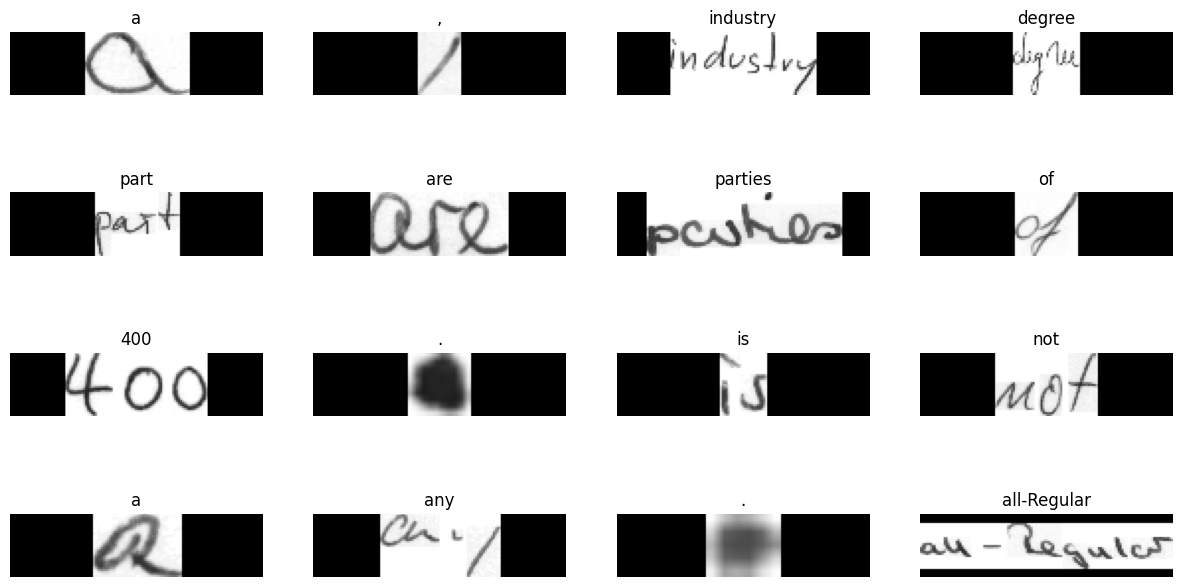

In [11]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

# Model

In [12]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

# Evaluation

In [13]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

# Edit Distance

In [14]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose=0)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f" Mean edit distance: {np.mean(edit_distances):.4f}"
        )

# Training

In [15]:
epochs = 50

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, early_stopping],
    verbose=1
)

Epoch 1/50
479/479 [==============================] - 59s 104ms/step - loss: 15.6828 - val_loss: 13.8657
Epoch 2/50
479/479 [==============================] - 47s 97ms/step - loss: 13.3846 - val_loss: 12.7067
Epoch 3/50
479/479 [==============================] - 47s 97ms/step - loss: 12.4628 - val_loss: 11.9263
Epoch 4/50
479/479 [==============================] - 47s 98ms/step - loss: 11.6136 - val_loss: 11.0978
Epoch 5/50
479/479 [==============================] - 47s 97ms/step - loss: 10.7872 - val_loss: 10.2447
Epoch 6/50
479/479 [==============================] - 47s 98ms/step - loss: 10.1254 - val_loss: 9.5498
Epoch 7/50
479/479 [==============================] - 48s 100ms/step - loss: 9.4520 - val_loss: 8.7963
Epoch 8/50
479/479 [==============================] - 47s 99ms/step - loss: 8.7574 - val_loss: 7.9874
Epoch 9/50
479/479 [==============================] - 47s 98ms/step - loss: 8.0944 - val_loss: 7.2198
Epoch 10/50
479/479 [==============================] - 47s 98ms/step 

# Save the Model

In [16]:
model.save('crnn_model_dt2.h5')
# model = load_model('crnn_model_dt2.h5')
# prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense_last").output)
# prediction_model.predict(batch_images)

# Inference

2/2 [==============================] - 0s 35ms/step


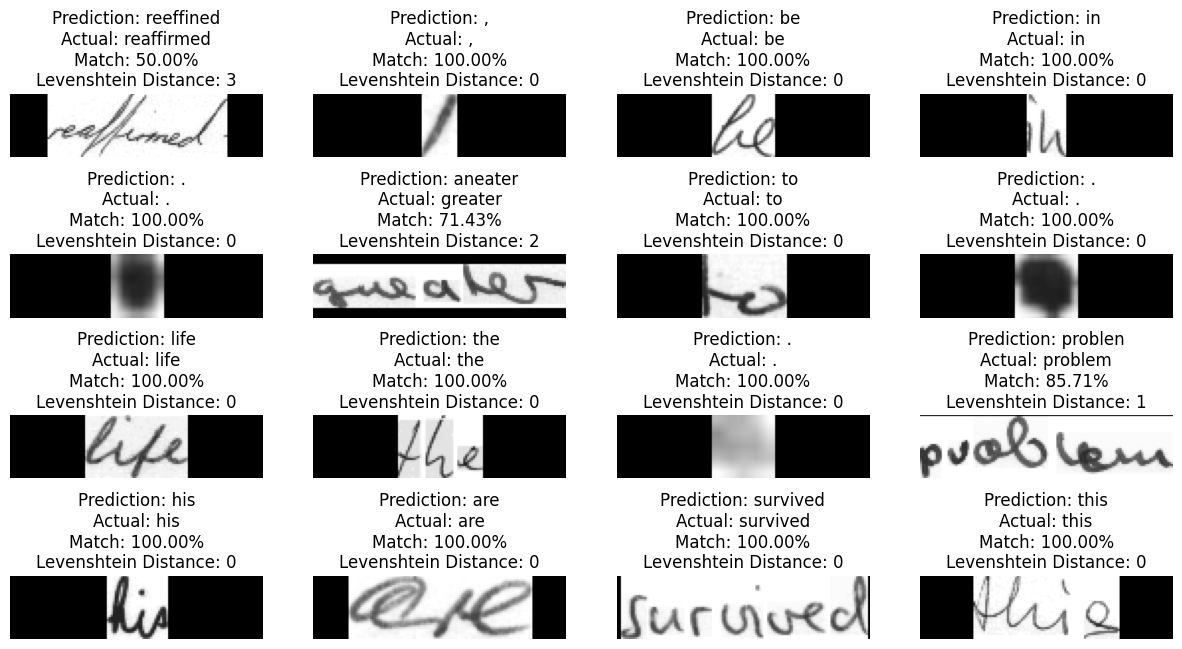

In [17]:
def calculate_match_percentage(actual, predicted):
    if len(actual) == 0:
        return 0.0
    match = sum([1 for a, b in zip(actual, predicted) if a == b])
    return match / len(actual)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        # Convert to string.
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]}\nActual: {batch_label}\nMatch: {calculate_match_percentage(batch_label, pred_texts[i]) * 100:.2f}%\nLevenshtein Distance: {levenshtein_distance(batch_label, pred_texts[i])}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Evaluation

Average Match Percentage: 40.52%
Average Levenshtein Distance: 0.38
Accuracy: 31.17%


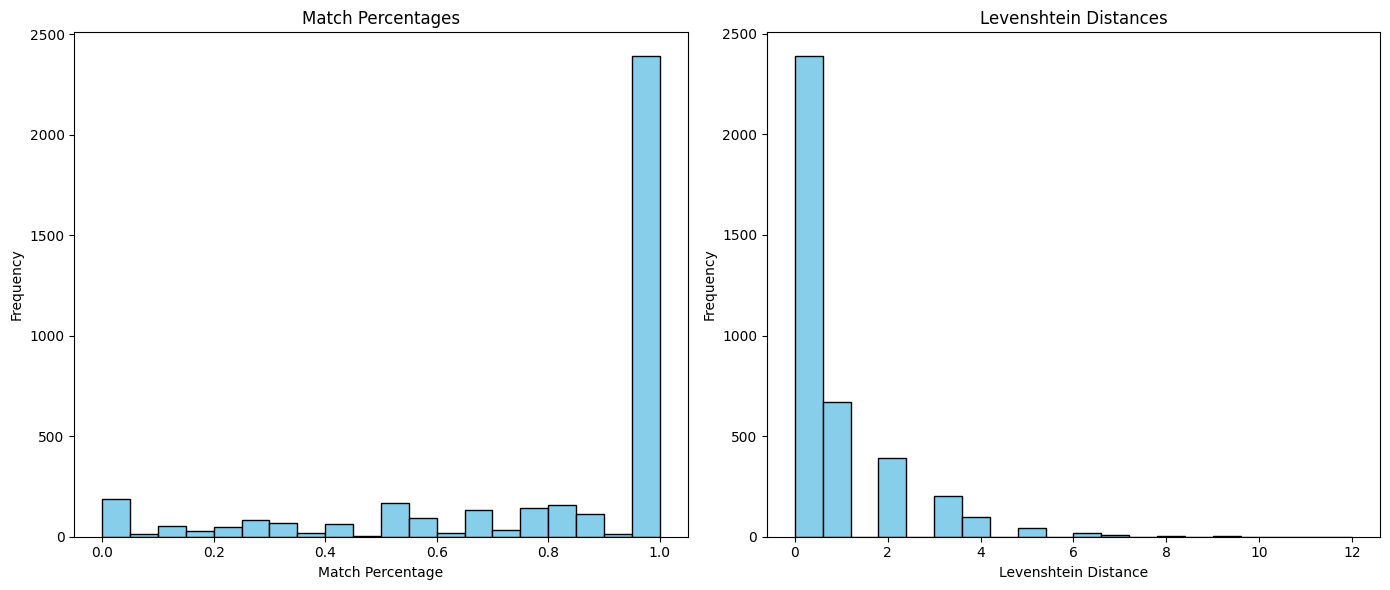

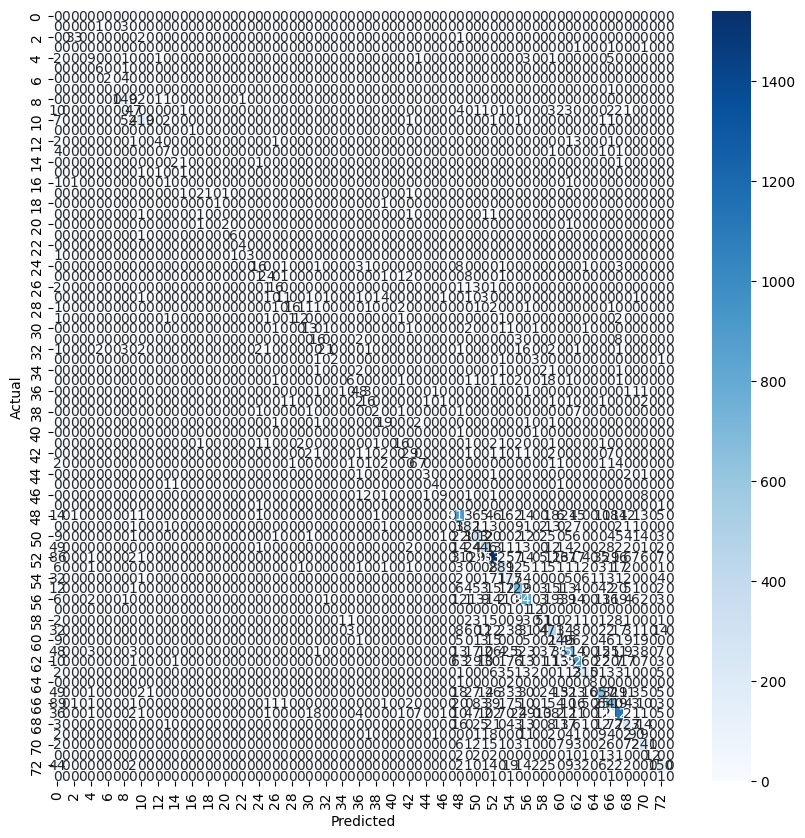

In [18]:
# Initialize counters
total_match_percentage = 0.0
total_levenshtein_distance = 0.0
total_samples = 0

total_exact_matches = 0
total_samples = 0

match_percentages = []
levenshtein_distances = []

actual_chars = []
predicted_chars = []

# Loop over all batches in the test dataset
for batch in test_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Make predictions
    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)

    # Loop over all predictions in the batch
    for i in range(len(pred_texts)):
        # Prepare the image
        img = batch_images[i]
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Prepare the label
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")

        # Check if prediction exactly matches the label
        if batch_label == pred_texts[i]:
            total_exact_matches += 1

        total_samples += 1
        
        # Calculate metrics
        match_percentage = calculate_match_percentage(batch_label, pred_texts[i])
        levenshtein_dist = levenshtein_distance(batch_label, pred_texts[i])

        # Store metrics
        match_percentages.append(match_percentage)
        levenshtein_distances.append(levenshtein_dist)
        
        # Update counters
        total_match_percentage += match_percentage
        total_levenshtein_distance += levenshtein_dist
        total_samples += 1
        
        # Pad or truncate the predicted text to the same length as the label
        pred_text = pred_texts[i]
        if len(pred_text) > len(batch_label):
            pred_text = pred_text[:len(batch_label)]
        elif len(pred_text) < len(batch_label):
            pred_text = pred_text.ljust(len(batch_label))
            
        # Add characters to lists
        actual_chars.extend(list(batch_label))
        predicted_chars.extend(list(pred_text))

# Calculate average metrics
average_match_percentage = total_match_percentage / total_samples
average_levenshtein_distance = total_levenshtein_distance / total_samples

print(f"Average Match Percentage: {average_match_percentage * 100:.2f}%") # Character Match
print(f"Average Levenshtein Distance: {average_levenshtein_distance:.2f}")

accuracy = total_exact_matches / total_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(match_percentages, bins=20, color='skyblue', edgecolor='black')
plt.title('Match Percentages')
plt.xlabel('Match Percentage')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(levenshtein_distances, bins=20, color='skyblue', edgecolor='black')
plt.title('Levenshtein Distances')
plt.xlabel('Levenshtein Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_chars, predicted_chars)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()